In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reversal Learning Parameter Setup

In [2]:
# define reversal learning task parameters
subject = 1
nStim = 2
ntrial = 135
volatility = ["high", "low"]  # 0 - high; 1 - low
taskVersion = [0 if (subject % 2) == 0 else 1][0] # if subject id is a even number, high/0
v = volatility[taskVersion]
prob= 0.70 # expected uncertainty aka probabilistic reward
nprob = 1 - prob
block_sequence_high = [17, 15, 19, 18, 15, 17, 19, 15]
block_sequence_low = [35, 30, 35, 35]
if taskVersion == 0:
    blockSequence = block_sequence_high
else:
    blockSequence = block_sequence_low

In [3]:
repeatn = len(blockSequence)/2
probTrial = [prob, nprob]*int(repeatn)

In [4]:
count = 0
t = 0
feedbackprob = []
feedback_1 = []
while count < len(blockSequence):
    for n in range(0, blockSequence[count]):
        feedbackprob.append(probTrial[count])
        feedback_1.append(np.random.random() <= feedbackprob[t])
        t = t + 1
    count = count + 1
feedback_2 = [not elem for elem in feedback_1]

In [5]:
feedback = np.column_stack((feedback_1, feedback_2))

# What would an ideal observer would do?

In [19]:
# define simulation parameters
alpha = 0.25
beta = 4
value_initial = [0.5, 0.5] # at first, the values of both options are 0.5 (neutral)
v = value_initial

outcome = feedback

choice_recorded = []

actual_choice = [1] * ntrial
actual_outcome = [1] * ntrial
loglik = 0

VV = [] # store value over trials
PP = [] # store choice probaility over trials

In [20]:
outcome_received_a = []
outcome_received_b = []
for t in range(0, ntrial):
    
    # compute probability of the two choice options
    ## softmax
    
    value_a = np.exp(beta*v[0])
    value_b = np.exp(beta*v[1])
    sum_ab = np.sum(value_a) + np.sum(value_b)
    pr_a = value_a/sum_ab
    pr_b = value_b/sum_ab
    p = [pr_a, pr_b]
    
    PP.append([pr_a, pr_b])
    
    # choose an action:
    # Do a weighted coinflip to make a choice: choose stim 1 if random
    # number is in the [0 p(1)] interval, and 2 otherwise
    if np.random.random()<pr_a:
        choice = 0
    else:
        choice = 1
        
    outcome_t = outcome[t, choice] # outcome at trial t given choice
    loglik = loglik+np.log(p[choice])
    
    # update values - Rescorla-Wagner Model
    prediction_error = outcome_t - v[choice]
    
    v_new = v[choice] + alpha*prediction_error
    if choice == 0:
        v = [v_new, v[choice+1]]
        VV.append(v)
    else:
        v = [v[choice-1], v_new]
        VV.append(v)    
    
    # record choice made during simulation at trial t
    choice_recorded.append(choice)

    if choice == 1:
        outcome_received_a.append(outcome_t)
        outcome_received_b.append("nan")
    else: 
        outcome_received_a.append("nan")
        outcome_received_b.append(outcome_t) 

outcome_received = np.column_stack((outcome_received_a, outcome_received_b))

In [21]:
length = max(map(len, VV))
y=np.array([xi+[None]*(length-len(xi)) for xi in VV])
value_a = y[:, 0:1]
value_b = y[:, 1:]

In [22]:
length = max(map(len, PP))
p=np.array([xi+[None]*(length-len(xi)) for xi in PP])
probability_b = p[:, 1:]

In [23]:
x_axis = np.arange(1, 136)

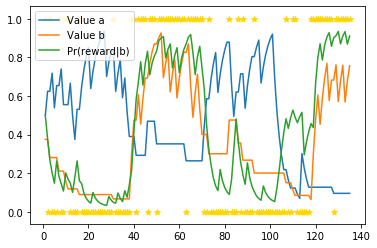

In [27]:
# plt.plot (x, pr_3, color = "gold")

plt.scatter (x_axis, choice_recorded, marker = "*", color = "gold")
plt.plot (x_axis, value_a, label = "Value a")
plt.plot (x_axis, value_b, label = "Value b")
plt.plot (x_axis, probability_b, label = "Pr(reward|b)")
plt.legend()